# FS25 Course Project 1: Word embeddings / RNN

By David Hodel

## Introduction

In this notebook, I present my solution to the first course project of the FS25 NLP module @ HSLU.

The task is to train answer commonsense question using word embeddings and RNNs. The CommonsenseQA ([Talmor et al., 2019](https://aclanthology.org/N19-1421/)) dataset is used for his purpose. The dataset consists of 12,247 questions with 5 choices each, where only one is correct. The questions are designed to require commonsense reasoning to answer correctly.

## Setup

We first import the necessary libraries to run the code.

In [2]:
import logging

from collections import Counter

from datasets import load_dataset
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from gensim.models import FastText

import nltk

We set up logging to get a better overview of the training process.

In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

We set up a fixed random seed to ensure reproducibility.

In [16]:
SEED = 42

We download the necessary files for the tokenizer from the `nltk` library.

In [3]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/david/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Data Splits

The data is available on Hugging Face: https://huggingface.co/datasets/tau/commonsense_qa.
Since only the train and validation splits have an answer key, we will use our own dataset splits.
We separate the last 1'000 samples from the training set as the validation set and use the original validation set as the test set.

In [4]:
train = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


## Data Exploration

First, we want to take a look at the data to understand its structure and content.

In [5]:
datasets = {
    "train": train,
    "validation": valid,
    "test": test
}

We ensure that all three splits have the same structure and that the answers are in the same format.

In [6]:
print(train.column_names)
assert train.column_names == valid.column_names == test.column_names

print(train[0])

unique_answers = set([ex["answerKey"] for ex in train] + [ex["answerKey"] for ex in valid] + [ex["answerKey"] for ex in test])
print(f"Unique answer keys: {unique_answers}")

['id', 'question', 'question_concept', 'choices', 'answerKey']
{'id': '075e483d21c29a511267ef62bedc0461', 'question': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?', 'question_concept': 'punishing', 'choices': {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}, 'answerKey': 'A'}
Unique answer keys: {'C', 'E', 'B', 'D', 'A'}


We then display a sample question and its answer for each split to get a feeling of the type of questions and answers.

In [7]:
for split, data in datasets.items():
    print(f"\n=== {split} Split ===")
    print(f"Question: {data[0]['question']}")
    for j, choice in enumerate(data[0]['choices']['text']):
        print(f"{chr(65+j)}) {choice}")  # A, B, C, etc.
    print(f"Correct Answer: {data[0]['answerKey']}")
    print("=" * 50)


=== train Split ===
Question: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
A) ignore
B) enforce
C) authoritarian
D) yell at
E) avoid
Correct Answer: A

=== validation Split ===
Question: What is a well known way for couples  of celebrating a marriage?
A) eat cake
B) getting drunk
C) having sex
D) cleaning rooms
E) drink too much
Correct Answer: C

=== test Split ===
Question: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?
A) bank
B) library
C) department store
D) mall
E) new york
Correct Answer: A


We plot the distribution of the answer keys (`A` - `E`) to see if there's a clear imbalance or pattern.

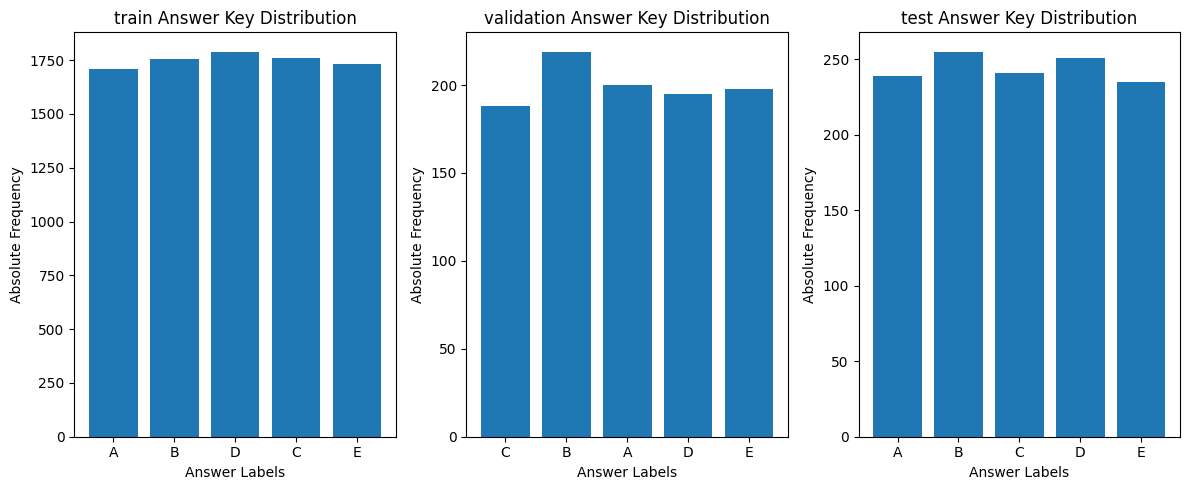

In [8]:
plt.figure(figsize=(12, 5))

for i, (split, data) in enumerate(datasets.items(), 1):
    answer_counts = Counter([ex["answerKey"] for ex in data])

    plt.subplot(1, 3, i)
    plt.bar(answer_counts.keys(), answer_counts.values())
    plt.xlabel("Answer Labels")
    plt.ylabel("Absolute Frequency")
    plt.title(f"{split} Answer Key Distribution")

plt.tight_layout()
plt.show()

We also plot the distribution of the number of characters in the questions.

Min. question length in split train: 15, max. length: 376
Min. question length in split validation: 20, max. length: 270
Min. question length in split test: 21, max. length: 279


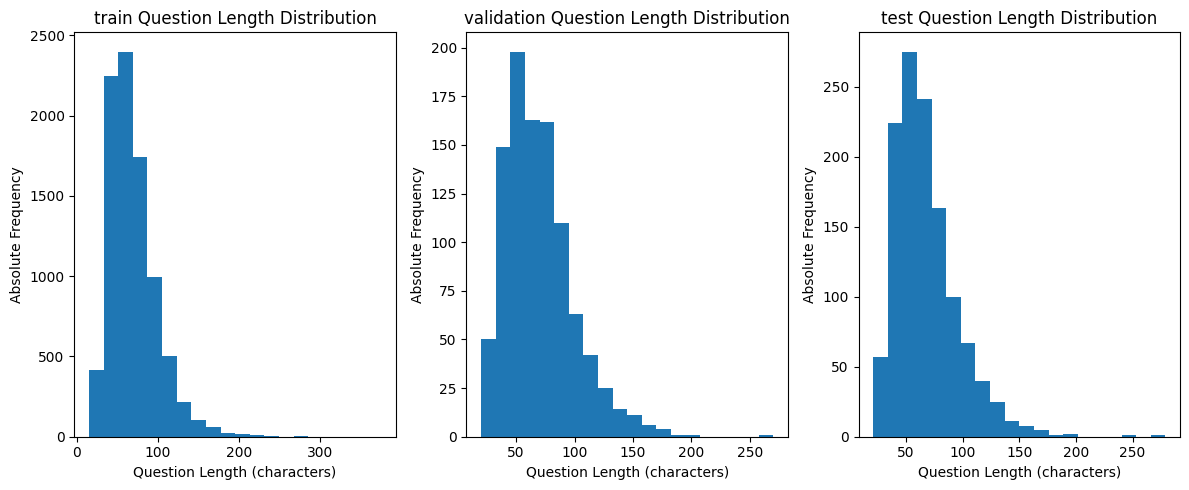

In [9]:
plt.figure(figsize=(12, 5))

for i, (split, data) in enumerate(datasets.items(), 1):
    question_lengths = [len(ex["question"]) for ex in data]

    plt.subplot(1, 3, i)
    plt.hist(question_lengths, bins=20)
    plt.xlabel("Question Length (characters)")
    plt.ylabel("Absolute Frequency")
    plt.title(f"{split} Question Length Distribution")
    print(f"Min. question length in split {split}: {min(question_lengths)}, max. length: {max(question_lengths)}")

plt.tight_layout()
plt.show()

## Preprocessing

Correct and justified decisions on:
o Tokenization
o Lowercasing, stemming, lemmatizing, stopword/punctuation removal
o Removal of unknown/other words
o Format cleaning (e.g. html-extracted text)
o Truncation
o Feature selection
o Input format: how is data passed to the model?
o Label format: what should the model predict?
o Batching, padding
o Vocabulary, embedding

First, we preprocess the raw text data to make it suitable for the model.
We use the word tokenizer from the `nltk` library to split the text into word tokens.
We don't lowercase the text as it may contain important information such as `I` or `US` and because fasttext can naturally handle different cases.
We also don't remove stopwords or punctuation as they may also contain important information for the model.
Stemming or lemmatization is not necessary as fasttext can handle different forms of words. Even more, it may be counterproductive as it may remove important information from the text such as time or location information.
Removal of unknown words is not necessary as fasttext word vectors are built from vectors of substrings of characters contained in it. This allows to build vectors even for misspelled words or concatenation of words.
As the longest question only has 376 characters, we don't need to truncate the text.
The text in the dataset is already clean and doesn't contain any html tags we would need to remove and / or parse. 

In short: The only preprocessing we do is tokenization.

In [10]:
def preprocess_text(text):
  preprocessed = word_tokenize(text)
  return preprocessed

In [11]:
all_sentences = []
for split, data in datasets.items():
    for example in data:
        all_sentences.append(preprocess_text(example["question"]))
        all_sentences.extend([preprocess_text(choice) for choice in example["choices"]["text"]])

print("Sample processed sentence:", all_sentences[0])

Sample processed sentence: ['The', 'sanctions', 'against', 'the', 'school', 'were', 'a', 'punishing', 'blow', ',', 'and', 'they', 'seemed', 'to', 'what', 'the', 'efforts', 'the', 'school', 'had', 'made', 'to', 'change', '?']


We then create the vocabulary and the word embeddings using the `fasttext` library.

In [24]:
model = FastText(
  sentences=all_sentences,
  vector_size=300, # dimensionality of the word vectors
  min_count=1, # include all words
  seed = SEED, # seed for the random number generator to ensure reproducibility 
  workers=1) # limit the model to a single worker thread to eliminate ordering jitter from OS thread scheduling to ensure reproducibility 

In [29]:
word_embeddings = model.wv

print(f"Vector size: {word_embeddings.vector_size}")
print(f"Vocab size: {len(word_embeddings.index_to_key)}")

print(word_embeddings.index_to_key[:10])
print(word_embeddings.index_to_key[-5:])

Vector size: 300
Vocab size: 13105
['?', 'to', 'a', 'the', 'what', ',', 'of', 'you', 'in', 'What']
['separating', 'handball', 'be/', 'feverishly', 'flippers']


We print out the embeddings of a word and of an out-of-vocabulary word to see if the embeddings are reasonable.

In [26]:
print(word_embeddings["blow"])
print(word_embeddings["icertainlydontexist"])

[ 1.47057578e-01 -2.57771790e-01 -8.68963599e-02  5.35827987e-02
 -9.43487361e-02 -1.43974423e-01  5.39747365e-02 -8.03844929e-02
  1.44575268e-01  3.19929838e-01 -1.39351606e-01 -1.16490461e-02
  1.05968788e-02 -4.20065559e-02 -8.31654109e-03  1.71322197e-01
 -9.76999756e-03 -3.57193202e-02 -1.45345926e-01  1.77523673e-01
  1.32000312e-01  1.70051575e-01  1.07899882e-01  1.32418334e-01
  2.46526420e-01  1.35637656e-01 -1.18806869e-01  1.21511310e-01
 -3.88209432e-01  6.97704926e-02  6.46917745e-02  1.05216697e-01
 -3.04111451e-01 -1.55761778e-01  3.96424420e-02 -1.51608720e-01
 -2.06848398e-01  1.64068520e-01  2.62035847e-01  1.45577386e-01
  1.55854568e-01 -1.77670851e-01  1.24321707e-01 -2.62891889e-01
  1.44604877e-01  1.48148239e-01 -1.01328604e-01  4.93497476e-02
 -2.29137596e-02  2.09039599e-01  6.91474006e-02  9.39761922e-02
  2.68732339e-01 -1.26782909e-01 -1.21458858e-01 -1.27979457e-01
  1.11711572e-03  1.38076201e-01  2.32283205e-01  6.54626787e-02
 -1.91143647e-01 -9.07615

## Model

## Training

## Evaluation

## Interpretation